In [52]:
import mne
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft #stft
from scipy.signal import butter, sosfiltfilt #signal filtering 
from scipy.interpolate import interp1d
import numpy as npy
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [53]:
#original file from MuseCrocMobile paper
#file_path = "2025-08-16_15_12_26_Muse_Recording.csv"

#Recorded w/ Unstable 8.1 app version
file_path = "MuseCrocMobile_2025-10-08_21_12_24_MS_03PRESET_1032_EEG@256Hz_Accelerometer@52Hz_Gyroscope@52Hz_DRL_REF@32Hz_Optics@64Hz_.csv"

#Whole raw file 
df = pd.read_csv(file_path)
df.head()

#total length of file in s and ms
total_length_ms = df['ms_ELAPSED'].iloc[-1] 
total_length_seconds = total_length_ms / 1000

for col_name in df.columns:
    print(col_name)

print(df.shape)

PACKET_TYPE
CLOCK_TIME
ms_ELAPSED
TP9_CONNECTION_STRENGTH(HSI)
TP9_ARTIFACT_FREE(IS_GOOD)
AF7_CONNECTION_STRENGTH(HSI)
AF7_ARTIFACT_FREE(IS_GOOD)
AF8_CONNECTION_STRENGTH(HSI)
AF8_ARTIFACT_FREE(IS_GOOD)
TP10_CONNECTION_STRENGTH(HSI)
TP10_ARTIFACT_FREE(IS_GOOD)
TP9_RAW
AF7_RAW
AF8_RAW
TP10_RAW
DRL
REF
TP9_DELTA_ABSOLUTE
AF7_DELTA_ABSOLUTE
AF8_DELTA_ABSOLUTE
TP10_DELTA_ABSOLUTE
TP9_THETA_ABSOLUTE
AF7_THETA_ABSOLUTE
AF8_THETA_ABSOLUTE
TP10_THETA_ABSOLUTE
TP9_ALPHA_ABSOLUTE
AF7_ALPHA_ABSOLUTE
AF8_ALPHA_ABSOLUTE
TP10_ALPHA_ABSOLUTE
TP9_BETA_ABSOLUTE
AF7_BETA_ABSOLUTE
AF8_BETA_ABSOLUTE
TP10_BETA_ABSOLUTE
TP9_GAMMA_ABSOLUTE
AF7_GAMMA_ABSOLUTE
AF8_GAMMA_ABSOLUTE
TP10_GAMMA_ABSOLUTE
TP9_DELTA_RELATIVE
AF7_DELTA_RELATIVE
AF8_DELTA_RELATIVE
TP10_DELTA_RELATIVE
TP9_THETA_RELATIVE
AF7_THETA_RELATIVE
AF8_THETA_RELATIVE
TP10_THETA_RELATIVE
TP9_ALPHA_RELATIVE
AF7_ALPHA_RELATIVE
AF8_ALPHA_RELATIVE
TP10_ALPHA_RELATIVE
TP9_BETA_RELATIVE
AF7_BETA_RELATIVE
AF8_BETA_RELATIVE
TP10_BETA_RELATIVE
TP9_GAMMA_RELA

In [54]:
#extracting only the rows triggered by EEG packets 
eeg_df = df[df['PACKET_TYPE'] == 'EEG']
#extracting only the EEG raw columns
rawEEG = eeg_df[['TP9_RAW', 'AF7_RAW', 'AF8_RAW', 'TP10_RAW']]

#Set file Collumn Names
eeg_columns = ['TP9_RAW', 'AF7_RAW', 'AF8_RAW', 'TP10_RAW']  # Adjust to your column names

eeg_data = rawEEG[eeg_columns].values.T  # Transpose to (n_channels, n_samples)

'''
Keep in mind -> 

MU_01 (PRESET_AB/PRESET_AD)- >

    NO FILTERING, so see the code in the MU_01_500Hz folder. AUX electrodes should be shielded! 

MU_01 All other Presets -> 

    DRL/REF works, signal is filtered differently than other muses and comes thru at 220 Hz

All other Presets and Muses -> 

    Notch filter can be applied in app at 50/60Hz, default is 60Hz Raw EEG is at 256 Hz, 
    pre-calculated frequency bands are done on-device and are 10Hz. 

'''

#file sampling rate: 
fs = 256

#expected number of samples
expected_sample_no = (fs/1000) * total_length_ms

#expected time between writes
expected_interWrite_ms = 1000/fs

eeg_df.head()

''' 
checking distance between packets to identify recording issues.

Please note that packets are generated by the Muse device at 64Hz, 
and this code is meant to evaluate application performance & 
write patterns. 

Packets are written to file at an uneven rate by the recieving 
device, and so recording stalls do not always mean missed 
data. 
'''

# Calculate the difference between consecutive rows
eeg_df['ms_diff'] = eeg_df['ms_ELAPSED'].diff()

#Printing text representig our data characteristics 
print(f"Original dataframe shape: {df.shape}")
print(f"Optics-only dataframe shape: {eeg_df.shape}\n")

print(f"Total Recording time in ms: {total_length_ms }")
print(f"Total Recording time in s: {total_length_ms/1000}")
print(f"Number of samples: {len(eeg_df)}\n")

print(f"Expected number of samples (ms precision): {expected_sample_no}\n")

#write stats 
print(f"Write Timing Stats: \n")
print(eeg_df['ms_diff'].describe())
print(f"\n")
#distance between writes based on fs
print(f"Expected Mean ms Between Writes : {expected_interWrite_ms}\n")
print(f"Actual Mean ms between: {eeg_df['ms_diff'].mean()}")
print(f"Max ms between: {eeg_df['ms_diff'].max()}")

Original dataframe shape: (66615, 80)
Optics-only dataframe shape: (29888, 81)

Total Recording time in ms: 129211
Total Recording time in s: 129.211
Number of samples: 29888

Expected number of samples (ms precision): 33078.016

Write Timing Stats: 

count    29887.000000
mean         4.321946
std         10.235660
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        258.000000
Name: ms_diff, dtype: float64


Expected Mean ms Between Writes : 3.90625

Actual Mean ms between: 4.321945996587145
Max ms between: 258.0


/tmp/ipykernel_20924/2752766513.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_df['ms_diff'] = eeg_df['ms_ELAPSED'].diff()


Creating RawArray with float64 data, n_channels=4, n_times=29888
    Range : 0 ... 29887 =      0.000 ...   116.746 secs
Ready.
<Info | 8 non-empty values
 bads: []
 ch_names: TP9, AF7, AF8, TP10
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 256.0 Hz
>
<RawArray | 4 x 29888 (116.8 s), ~945 KiB, data loaded>


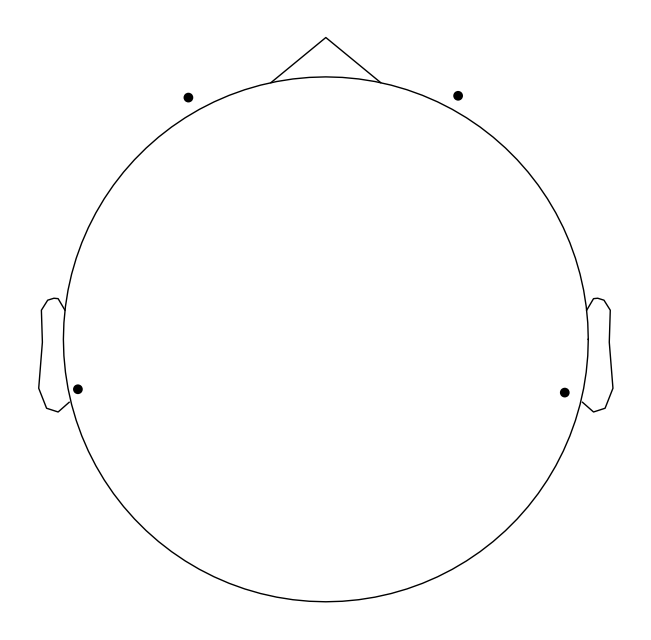

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/home/m/Desktop/Projects - Local/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


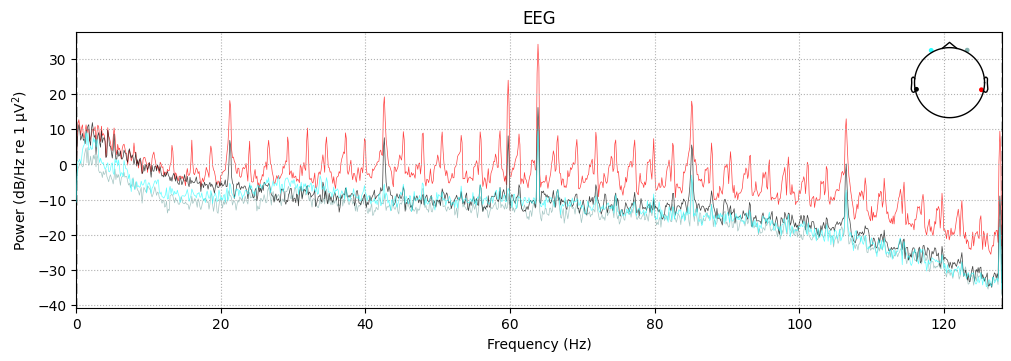

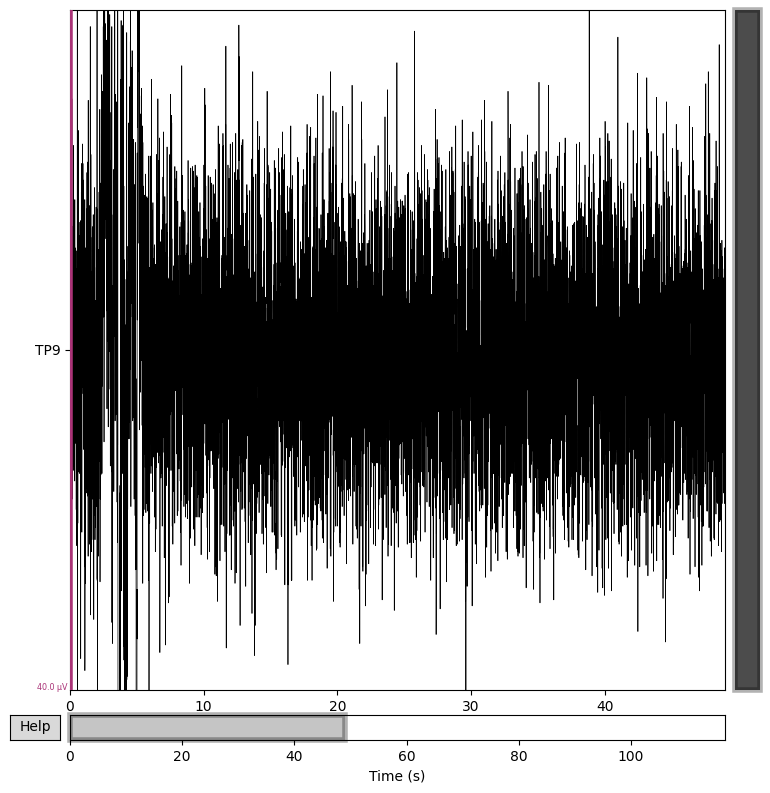

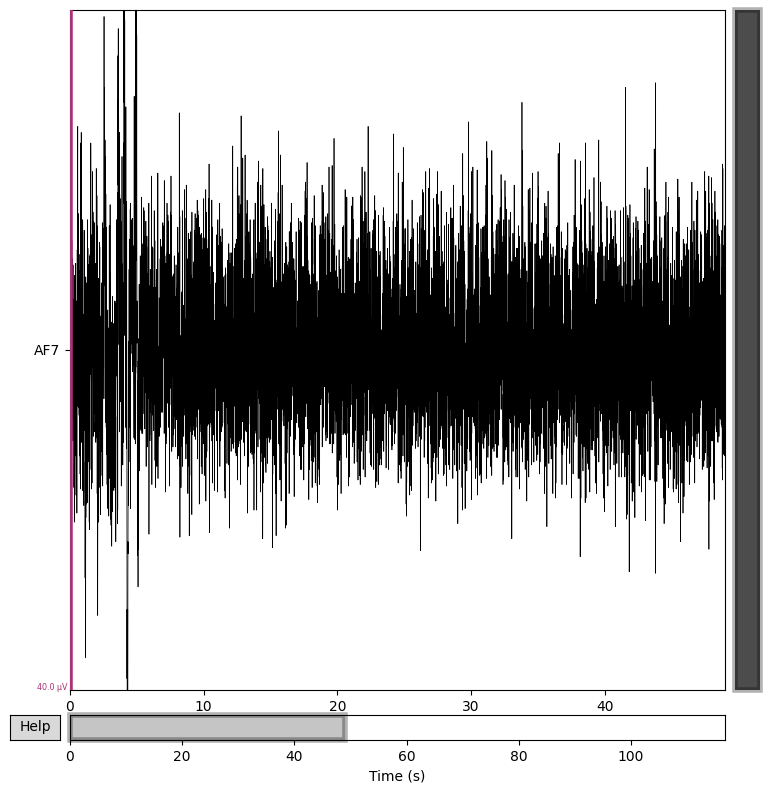

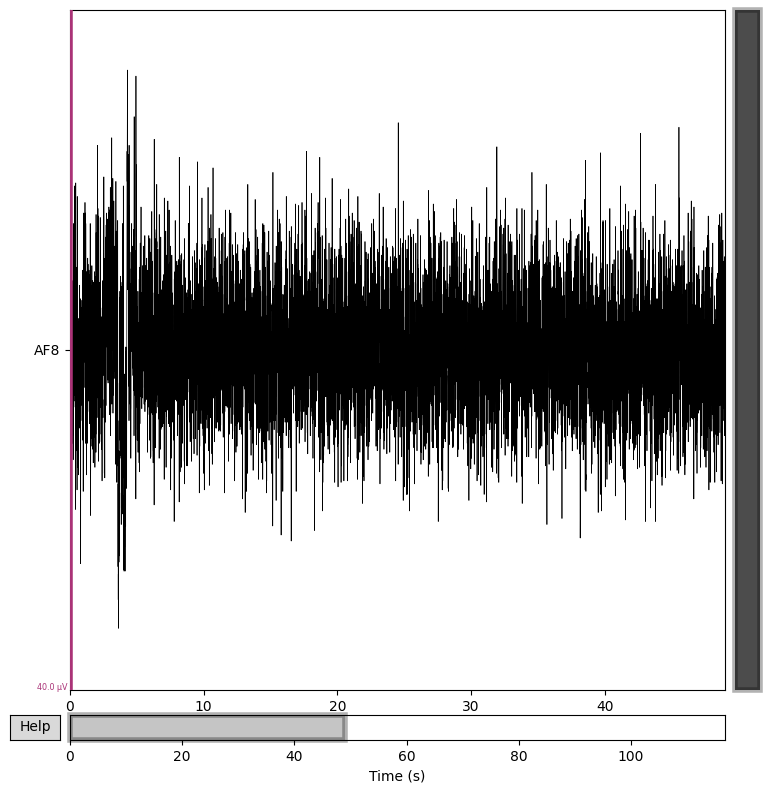

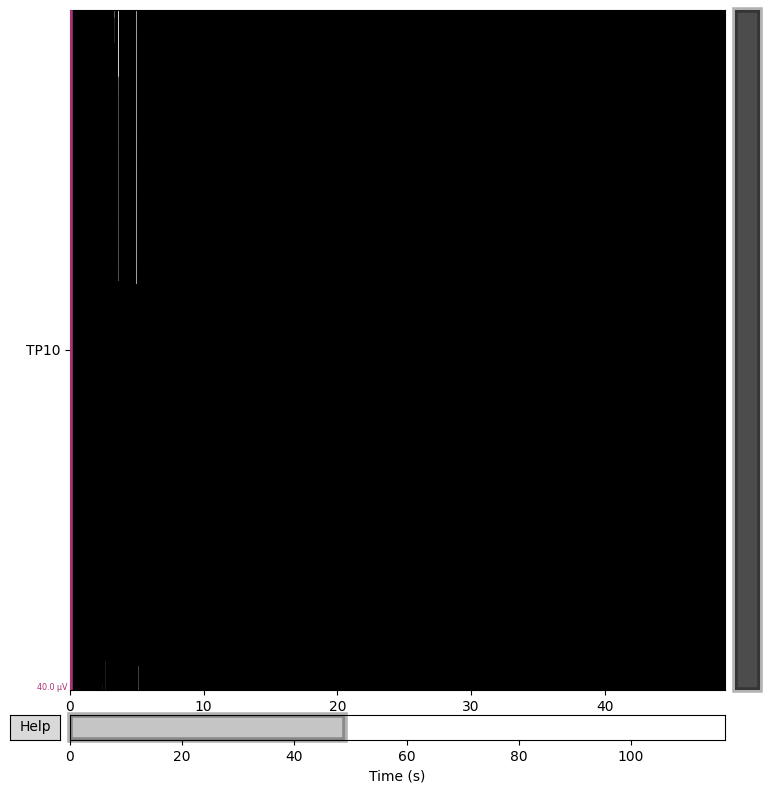

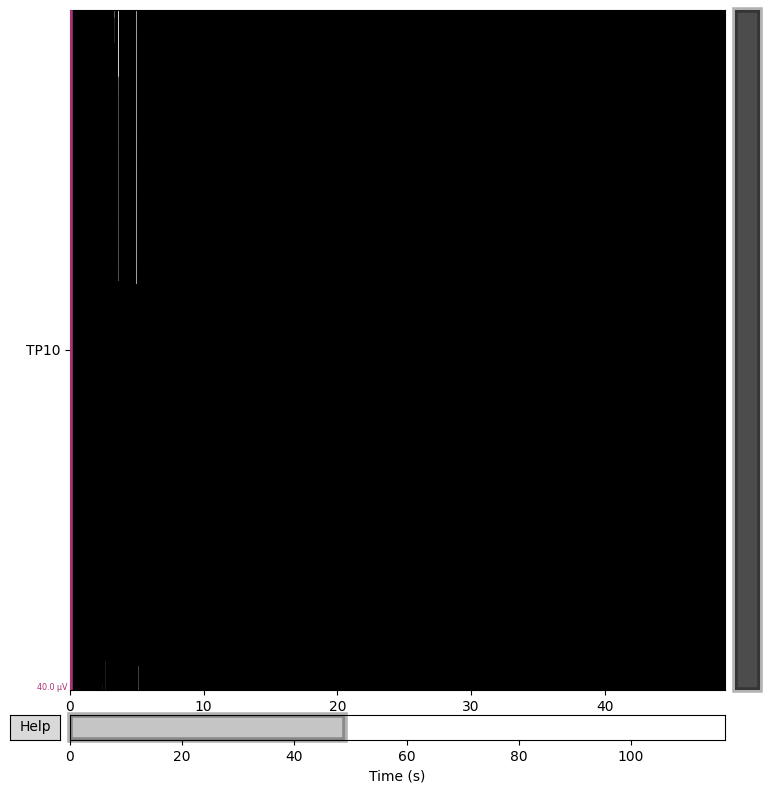

In [55]:
''' 
Unfiltered data! See filtered below. 
'''

#Create Info object
ch_names = ['TP9', 'AF7', 'AF8', 'TP10'] # Set channel names
#ch_names = ['TP9', 'AF7', 'AF8', 'TP10', "AUX_LEFT", "AUX_RIGHT"] # Set channel names to include AUX if you want
ch_types = ['eeg'] * len(ch_names) # Set channel types to EEG
sfreq = 256  # Sampling frequency in Hz (adjust to your data)

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

#Set montage for sensor positions
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

#turning data into volts from uV ajd creating raw object
data_volts = eeg_data * 1e-6
raw = mne.io.RawArray((data_volts), info)

#printing info 
print(raw.info)
print(raw)

#Plot EEG sensor locations 
raw.plot_sensors(ch_type="eeg")

#Plot PSD for all electrodes 
raw.compute_psd(fmax=128).plot(picks="data", exclude="bads", amplitude=False)

#plot EEG by electrode
raw.plot(duration=49, n_channels=1, picks="TP9")
raw.plot(duration=49, n_channels=1, picks="AF7")
raw.plot(duration=49, n_channels=1, picks="AF8")
raw.plot(duration=49, n_channels=1, picks="TP10")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 s)

<Info | 8 non-empty values
 bads: []
 ch_names: TP9, AF7, AF8, TP10
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.1 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 256.0 Hz
>
<RawArray | 4 x 29888 (116.8 s), ~945 KiB, data loaded>


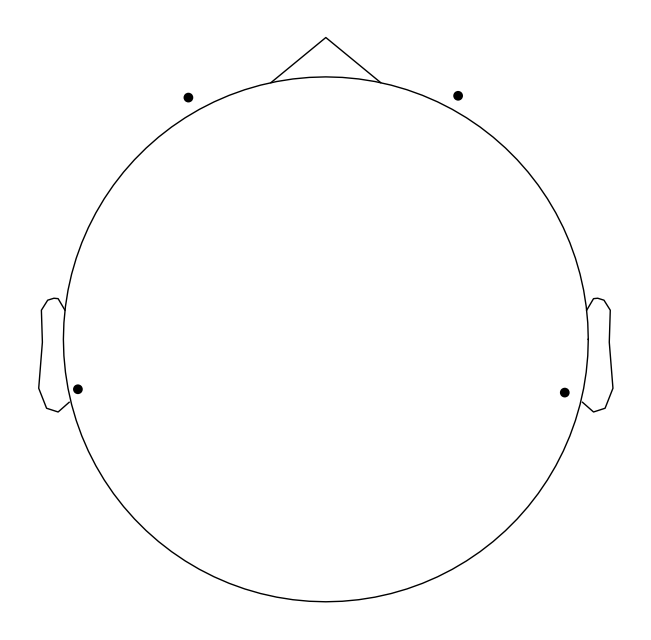

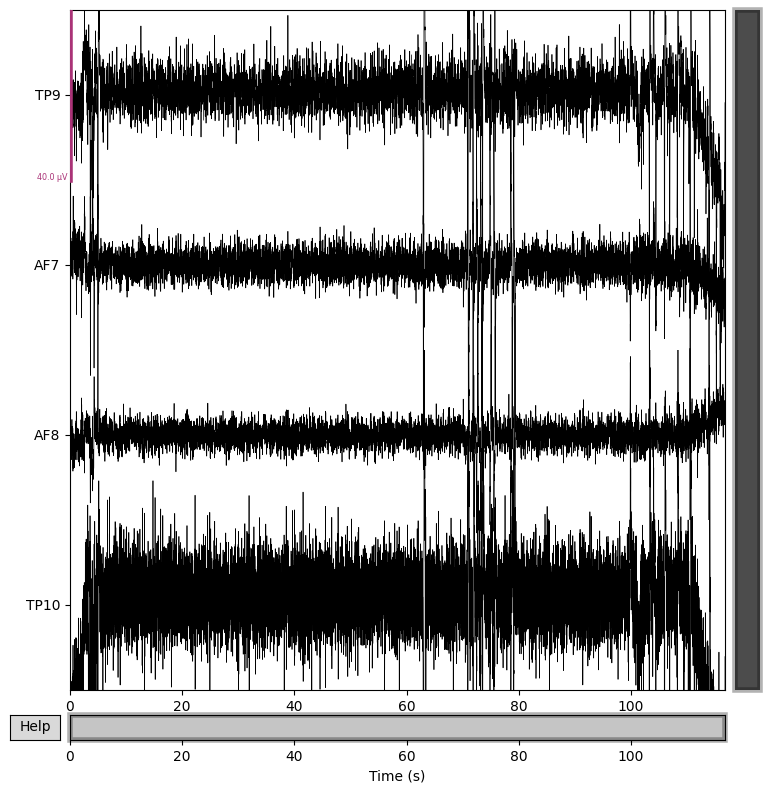

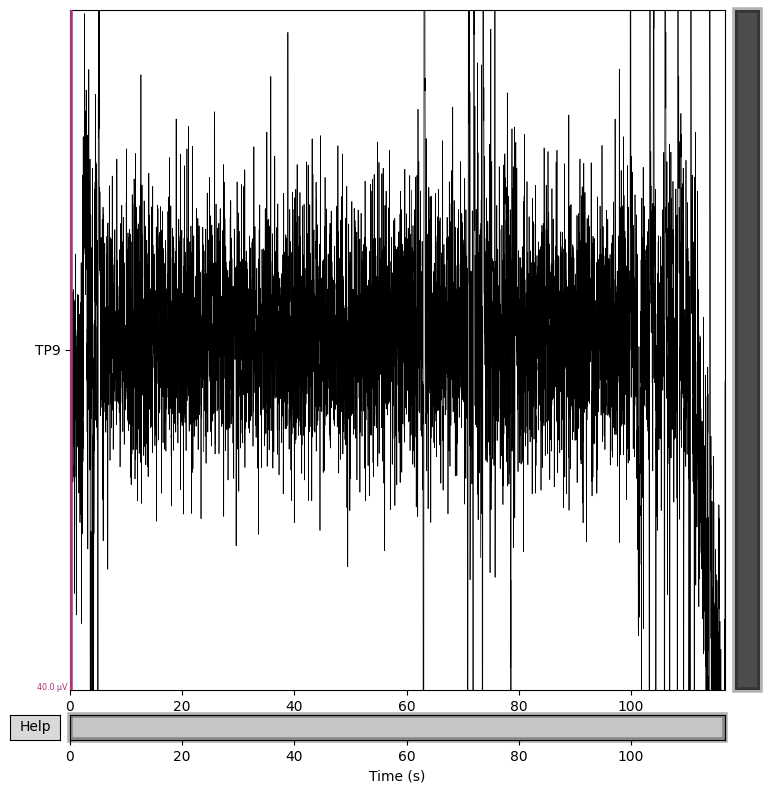

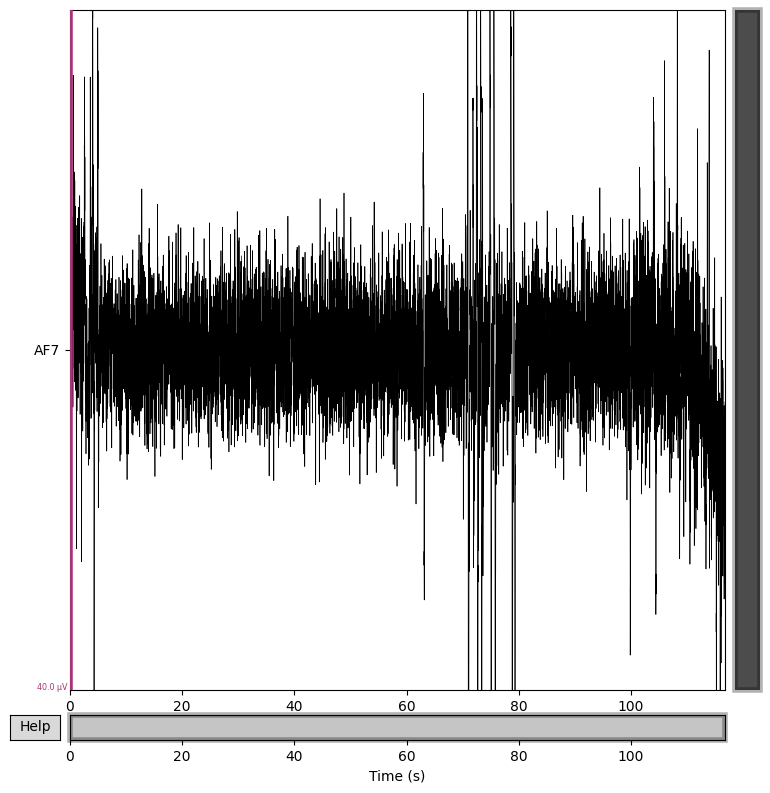

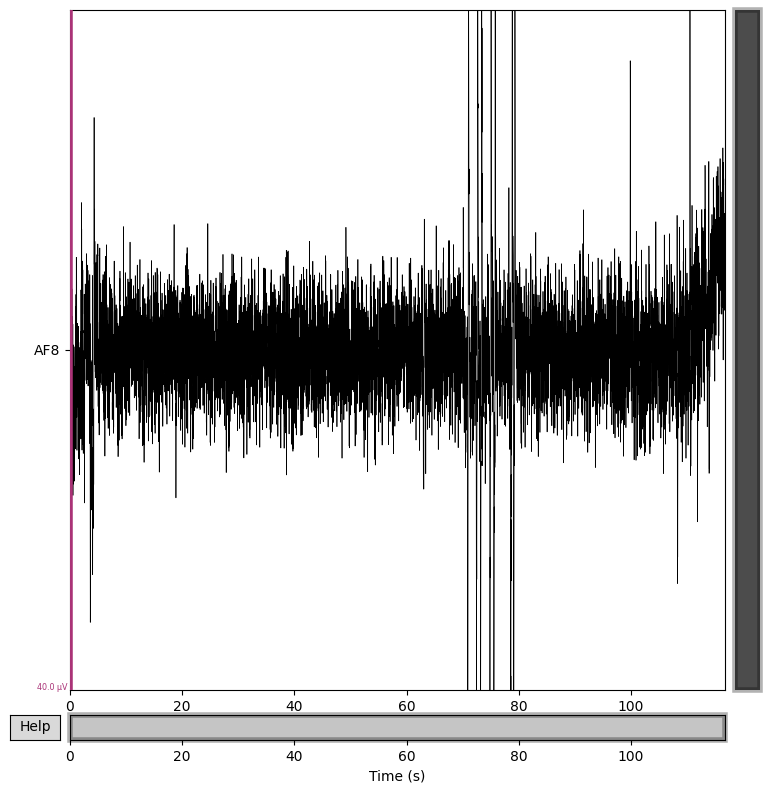

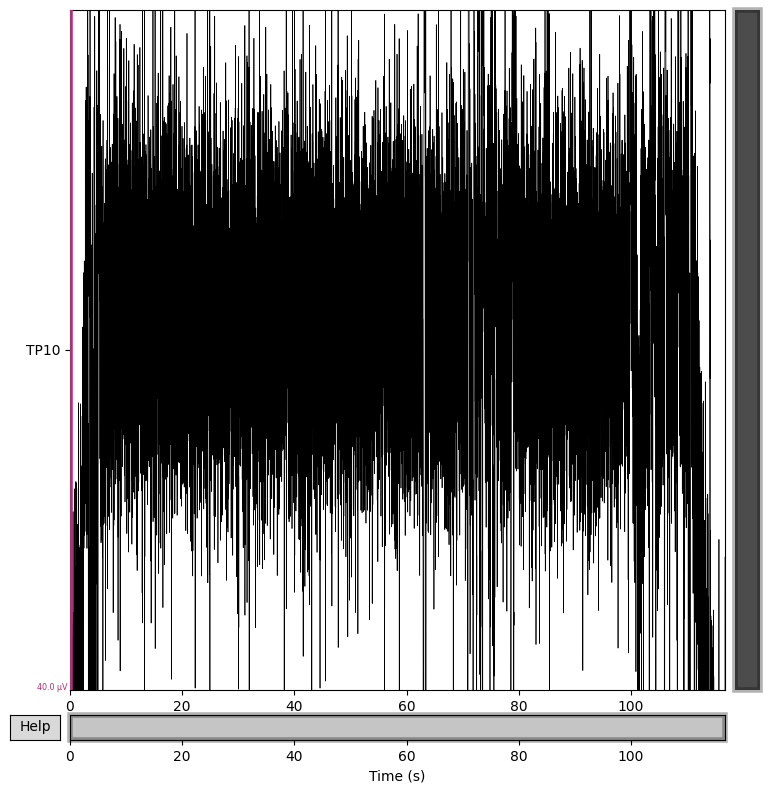

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/home/m/Desktop/Projects - Local/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


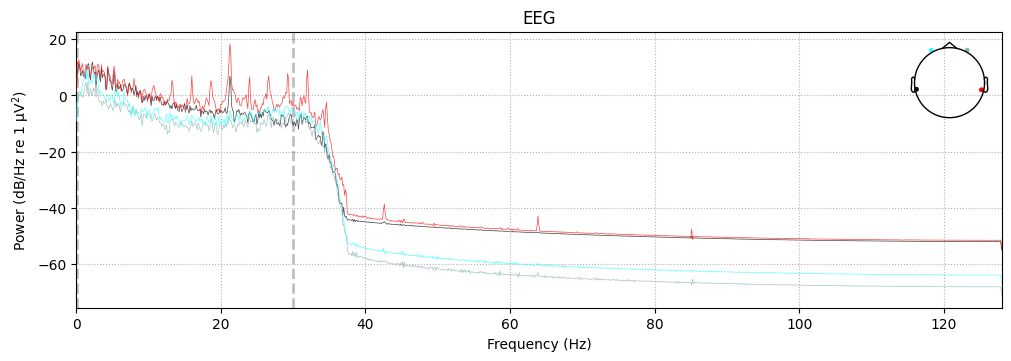

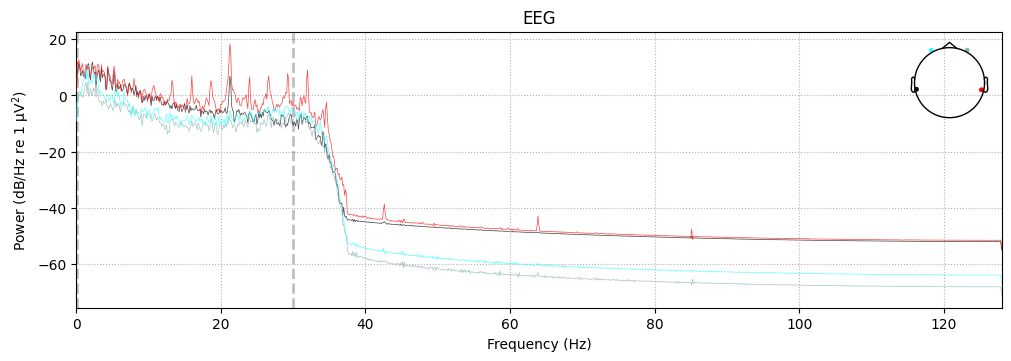

In [56]:
''' 
Filtered Data 
'''
#filtering raw 
# https://neuraldatascience.io/7-eeg/erp_filtering.html

# Filter settings
low_cut = 0.1
hi_cut  = 30
#apply filter - band pass from 0.1 - 30 Hz
filtered_raw = raw.copy().filter(low_cut, hi_cut)

#printing info 
print(filtered_raw.info)
print(raw)

#Plot EEG sensor locations 
filtered_raw.plot_sensors(ch_type="eeg")

#plot all filtered raw
filtered_raw.plot(start=0, duration=total_length_seconds);  # times are in seconds

#plot EEG by electrode
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="TP9")
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="AF7")
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="AF8")
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="TP10")

#Plot PSD, max freq is our nyquist freq
filtered_raw.compute_psd(fmax=128).plot(picks="data", exclude="bads", amplitude=False)